# PyMC3 Introduction

Last revised 18-Jun-2019 by Dick Furnstahl (furnstahl.1@osu.edu)

A good starting point for notebooks with PyMC3 examples is the official documentation site: https://docs.pymc.io/.  We've adapted some examples from that site here and in other notebooks.

**Aside.** Here is a good quote from Rob Hicks on HMC and No U-Turn:

"The idea: rather than blindly stumbling around the posterior, use the posterior gradient to skate around the gradient contour. As you skate closer to a drop-off (gradient is steep and probability is lower), potential energy decreases and kinetic energy increases (since energy is always conserved). When this happens the skater is turned back uphill and pushed from the precipice and skates on along a posterior likelihood contour. The No U-Turn sampler keeps skating until the skater tries to turn back towards the original point."

## Imports

In [1]:
import numpy as np
import scipy.stats as stats

import pymc3 as pm
import theano as tt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

# Recommended: document what PyMC3 version we are using
print(f'Running on PyMC3 v{pm.__version__}')


Running on PyMC3 v3.11.2


## Basic setup of a model

First we need to create a *model*, which will be an instance of the Model class.  The model has references to all random variables (RVs) and computes the model log posterior (logp) and its gradients.  We typically instantiate it using a with context.  For example:

In [2]:
with pm.Model() as my_model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

So `my_model` is an instance of the PyMC3 Model class, and we have set up a prior for `mu` in the form of a standard normal distribution (i.e., mean = 0 and standard deviation = 1).  The last line sets up the likelihood, also distributed as a normal with observed data taken as 100 random draw from a standard normal distribution.  The standard deviation sd for the mu posterior is given.  The goal will be to sample the posterior for mu.

## Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.



As you can see, on a continuous model, `PyMC3` assigns the NUTS sampler, which is very efficient even for complex models. `PyMC3` also runs variational inference (i.e. `ADVI`) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [avg]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # Remove the CWD from sys.path while we load stuff.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


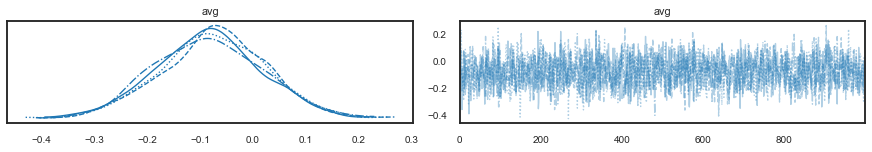

In [3]:
with pm.Model() as my_NUTS_model:
    avg = pm.Normal('avg', mu=0, sigma=1)
    
    model = avg
    
    obs = pm.Normal('obs', mu=model, sigma=1, observed=np.random.randn(100))

    trace_NUTS = pm.sample(1000, tune=1000)

pm.traceplot(trace_NUTS);


### Available samplers

`PyMC3` offers a variety of samplers, found in pm.step_methods:

In [4]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

Commonly used step-methods besides NUTS are Metropolis and Slice. The claim is that for almost all continuous models, ``NUTS`` should be preferred. There are hard-to-sample models for which NUTS will be very slow causing many users to use Metropolis instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample.  Here is an example (Metropolis-Hastings):



/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


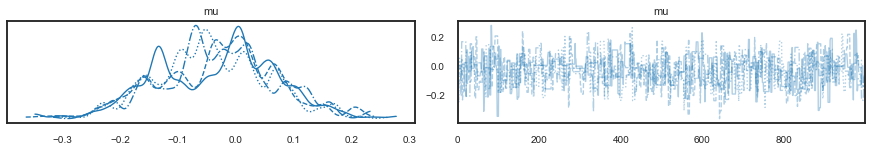

In [5]:
with pm.Model() as my_Metropolis_model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace_MH = pm.sample(1000, step=step)

pm.traceplot(trace_MH);

### Analyze sampling results

The most common used plot to analyze sampling results is the so-called trace-plot:

/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


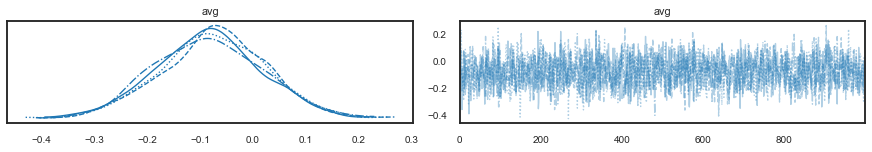

In [6]:
pm.traceplot(trace_NUTS);


/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # Remove the CWD from sys.path while we load stuff.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


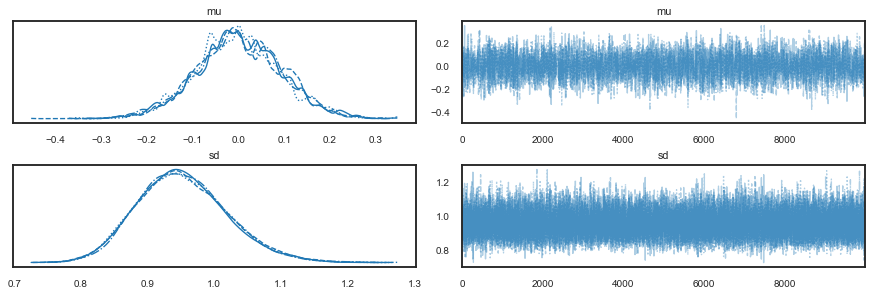

In [7]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace_2_samplers = pm.sample(10000, step=[step1, step2], cores=4)

pm.traceplot(trace_2_samplers);


### Diagnostics

In [8]:
pm.gelman_rubin(trace_MH)

AttributeError: module 'pymc3' has no attribute 'gelman_rubin'

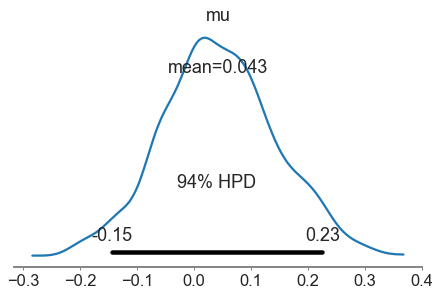

In [9]:
pm.plot_posterior(trace_MH);


## Examples from Rob Hicks

See https://rlhick.people.wm.edu/stories/bayesian_7.html.  We also have a notebook from his Bayesian 8 "story".

We start with a very simple one parameter model and then move to slightly more complicated settings:

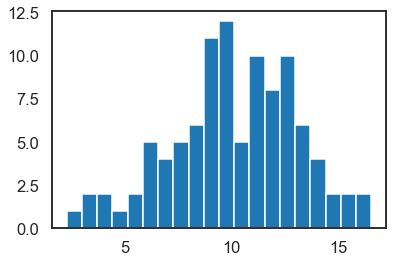

In [9]:
sigma = 3.  # standard deviation
mu = 10.    # mean
num_samples = 100  # 10**6

# sample from a normal distribution
data = stats.norm(mu, sigma).rvs(num_samples)  

# plot a histogram of the sampled data
num_bins = 20
plt.hist(data, bins=num_bins)
plt.show()


Run the previous cell a few times to see the fluctuations.  Crank up the number of samples to `10**6` to see a smoother histogram.

### PyMC3 implementation

We instantiate a Model with a descriptions of priors and the likelihood. Here, `mu` is defined to be a random variable (we want to sample this variable by generating a Markov chain) and we provide a prior distribution with associated hyper-parameters for it. The likelihood function is chosen to be Normal, with one parameter to be estimated (mu), and we use known $\sigma$ (denoted as `sigma`). Our "dependent variable" is given by `observed=data`, where `data` is generated above and shown in the histogram. So we our implementing Bayes theorem in the form:  
\begin{align}
   \newcommand{\Pr}{\textrm{pr}} 
   \newcommand{\data}{\textbf{data}}
   \Pr(\mu | \sigma, \data) \propto \Pr(\data | \mu, \sigma) \times \Pr(\mu |\mu^0_\mu, \sigma^0_\mu)
\end{align}

In [10]:
# parameters for the prior on mu
mu_prior = 8.
sigma_prior = 1.5  # Note this is our prior on the std of mu

# Could do this instead as:
#   basic_model = pm3.Model()
#   with basic_model:

with pm.Model() as basic_model:  

    # Prior for unknown model parameters (mean and sd of the normal pdf)
    mu = pm.Normal('Mean of Data', mu_prior, sigma_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=data)


Next we define how the Markov chain will be constructed. The example we are following set `startvals` to be the MAP and used a Metropolis step method.  There always seems to be a complaint with the latest pyMC3 about using find_MAP to start the sampler.

In [11]:
chain_length = 10000

with basic_model:
    # obtain starting values via MAP (maximum a posteriori)
    startvals = pm.find_MAP(model=basic_model)  # model here is optional
    print(startvals)
    
    # instantiate sampler
    step = pm.Metropolis()   # Metropolis-Hastings

    # draw 10000 posterior samples for each chain (4 chains by default?)
    trace = pm.sample(draws=chain_length, step=step, start=startvals) 
    #trace = pm.sample(chain_length, step=step) 


{'Mean of Data': array(10.01826153)}


/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Mean of Data,10.018,0.294,9.48,10.59,0.003,0.002,8089.0,9010.0,1.0


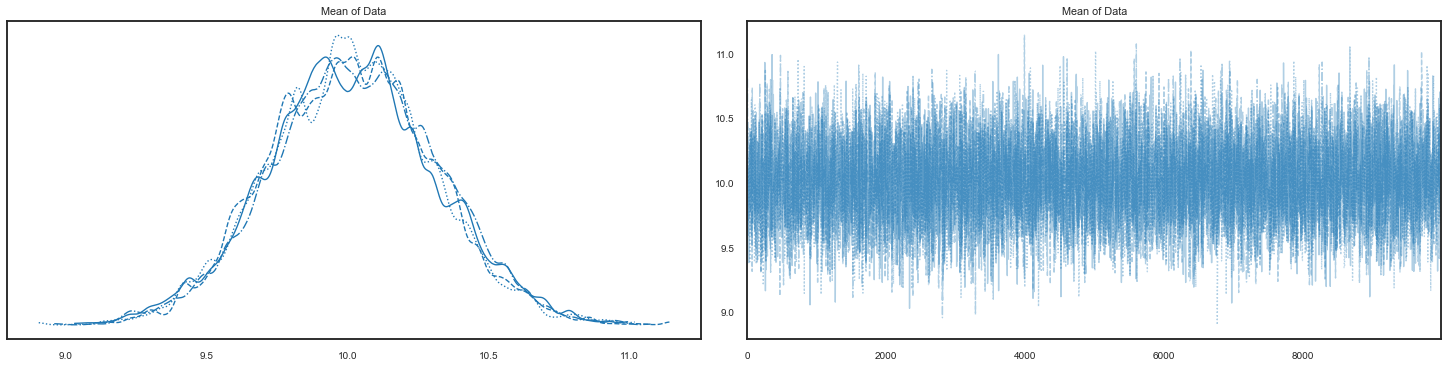

In [12]:

# Plot the four chains
pm.traceplot(trace, figsize=(20,5));

# Summary information on the Markov chains
pm.summary(trace)


Remember that what we are generating is a posterior for the mean given the data and our (assumed) knowledge of the standard deviation.

So for the summary info we get the mean and standard deviation (sd) of the distribution, with an estimate of the Monte Carlo error. What does hpd stand for?  "Highest posterior density"  2.5 and 97.5 are percentages, so one talks of a 95% hpd interval in this case. 

From an answer online: "You create the parameter trace plots to make sure that your a priori distribution is well calibrated which is indicated by your parameters having sufficient state changes as the MCMC algorithm runs."


"All the results are contained in the trace variable. This is a pymc3 results object. It contains some information that we might want to extract at times. `Varnames` tells us all the variable names setup in our model."

In [13]:
trace.varnames

['Mean of Data']

This was set up when we initiated our model (in specifying the prior for mu).  With the variable names, we can extract chain values for each variable:

In [14]:
trace['Mean of Data']


array([10.43303639, 10.43303639, 10.15173273, ...,  9.84647352,
        9.84647352,  9.6235404 ])

Is this one chain or all four chains?  Check the length!  Looks like all four.

In [15]:
print(len(trace['Mean of Data']))
print(trace['Mean of Data'].shape)

40000
(40000,)


Now for diagnostics.

### Autocorrelation plots


/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
/Users/furnstah/opt/anaconda3/envs/8805-env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


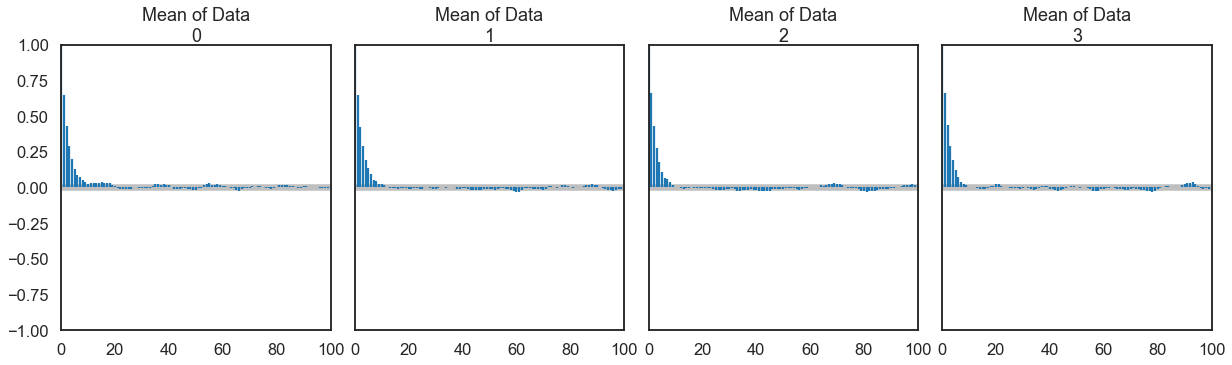

In [16]:
pm.plots.autocorrplot(trace,figsize=(17,5));

What do we see here?  An autocorrelation time around 10 or so.

### Acceptance rate

In [17]:
accept = np.sum(trace['Mean of Data'][1:] != trace['Mean of Data'][:-1])
print("Acceptance Rate: ", accept/trace['Mean of Data'].shape[0])


Acceptance Rate:  0.337275


That looks like we have to work harder than one might have expected.  It is taking the array of results and comparing each point to the previous one and including it in the sum if it is different.  So if there wasn't an acceptance, then the point remains the same.  The ratio to the full length is the acceptance rate.  Maybe we should define a function here instead.

In [18]:
def acceptance_rate(trace_array):
    """Calculate how many times the entry in the trace array changed compared
       to the total length.
    """
    changed = np.sum(trace_array[1:] != trace_array[:-1])
    total_length = trace_array.shape[0]
    return changed / total_length

In [19]:
acceptance_rate(trace['Mean of Data'])

0.337275

### Geweke Score

From a different lecture:

We can explicitly think of this test as a test for the Ergodicity (stationarity) of your chain.

Take the first 10 and last 50% of your chain and do a z test comparing means (correcting for autocorrelation). Software packages, take this a step further: The geweke function in pymc3 by default chooses the first 10% of your chain, and the final 50%; divides the final 50% of the chain into 20 segments and performs a z-test for each segment. You want to fail to reject the null, since the hypothesis is:

H0:θ10%=$θs50%H1:θ10%≠$θs50%
for each segment s. If our means are the same (we fail to reject the null), then we have strong evidence of chain convergence.

In [20]:
score=pm.geweke(trace, first=0.1, last=0.5, intervals=20)
score

AttributeError: module 'pymc3' has no attribute 'geweke'

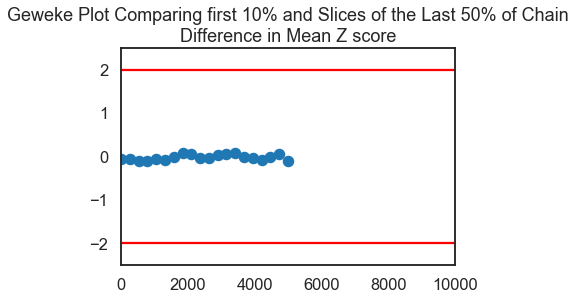

In [22]:
score=pm.geweke(trace, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
plt.title('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in Mean Z score')
plt.show()

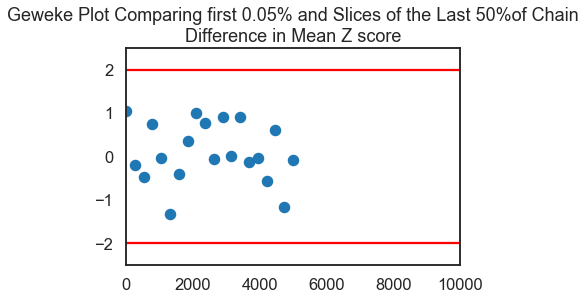

In [23]:
score=pm.geweke(trace, first=0.0005, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], 
            marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
my_title = 'Geweke Plot Comparing first 0.05% and Slices of the Last 50%' +\
           'of Chain\nDifference in Mean Z score'
plt.title(my_title)
plt.show()

From a different lecture: "Even without dropping any burn-in observations, we have convergence. We only start seeing issues when we restrict ourselves to the first 5 values in the chain. Suggests we should drop the first few dozen observations for burn-in."

### Gelman Rubin Diagnostic (quoted verbatim from the Hicks notebook)

If our MH MCMC Chain reaches a stationary distribution, and we repeat the excercise multiple times, then we can examine if the posterior for each chain converges to the same place in the distribution of the parameter space.

Steps:
1. Run $M>1$ Chains of length $2 \times N$.
2. Discard the first $N$ draws of each chain, leaving $N$ iterations in the chain.
3. Calculate the within and between chain variance.
    * Within chain variance:
    $$
    W = \frac{1}{M}\sum_{j=1}^M s_j^2 
    $$
    where $s_j^2$ is the variance of each chain (after throwing out the first $N$ draws).
    * Between chain variance:
    $$
    B = \frac{N}{M-1} \sum_{j=1}^M (\bar{\theta_j} - \bar{\bar{\theta}})^2
    $$
    
    where $\bar{\bar{\theta}}$ is the mean of each of the M means.
4. Calculate the estimated variance of $\theta$ as the weighted sum of between and within chain variance.
$$
\hat{var}(\theta) = \left ( 1 - \frac{1}{N}\right ) W + \frac{1}{N}B
$$
5. Calculate the potential scale reduction factor.
$$
\hat{R} = \sqrt{\frac{\hat{var}(\theta)}{W}}
$$

We want this number to be close to 1.  Why?  This would indicate that the between chain variance is small.  This makes sense, if between chain variance is small, that means both chains are mixing around the stationary distribution.  Gelmen and Rubin show that when $\hat{R}$ is greater than 1.1 or 1.2, we need longer burn-in.


In [24]:
chain_length = 100000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm.Metropolis() 

    # draw 5000 posterior samples
    trace = pm.sample(chain_length, step=step, start=startvals)

/Users/furnstah/anaconda3/envs/8805-env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -293.91, ||grad|| = 26.914: 100%|██████████| 4/4 [00:00<00:00, 2174.06it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]


{'Mean of Data': array(10.32913725)}


Sampling 4 chains: 100%|██████████| 402000/402000 [00:53<00:00, 7576.70draws/s] 
The number of effective samples is smaller than 25% for some parameters.


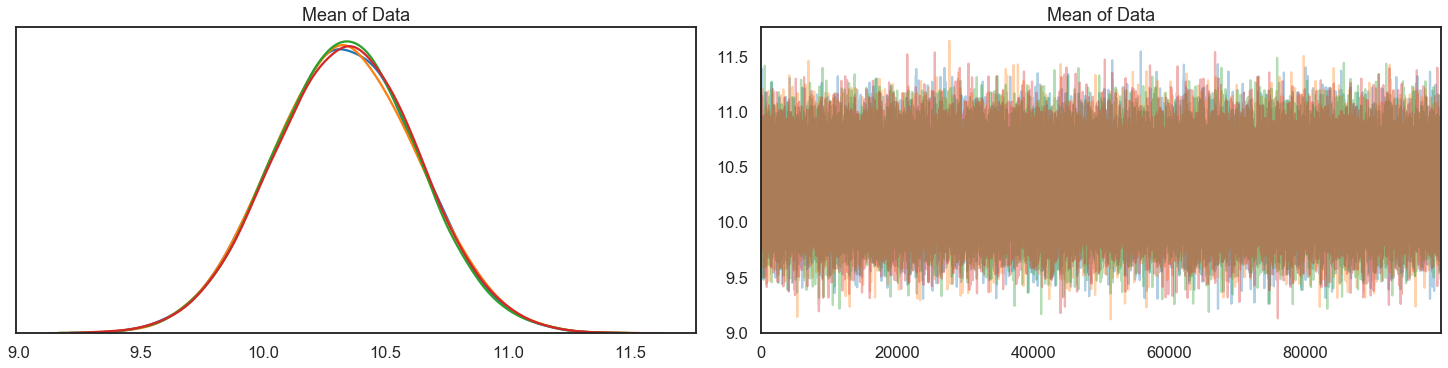

In [25]:
pm.traceplot(trace,figsize=(20,5));

In [26]:
pm.gelman_rubin(trace)

{'Mean of Data': 1.0000279269613919}

"Based on Gelman-Rubin and Geweke, we can be confident we have a chain that has converged to the limiting distribution (although perhaps for Gelman-Rubin, we'd want to try different starting values rather than MAP)."

Trying without `find_MAP`, i.e., not specifying `start` in `pm.sample`.

In [27]:
chain_length = 100000 

with basic_model:
    # obtain starting values via MAP
    #startvals = pm.find_MAP(model=basic_model)
    #print(startvals)
    # instantiate sampler
    step = pm.Metropolis() 

    # draw 5000 posterior samples
    trace = pm.sample(chain_length, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]
Sampling 4 chains: 100%|██████████| 402000/402000 [01:11<00:00, 5635.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


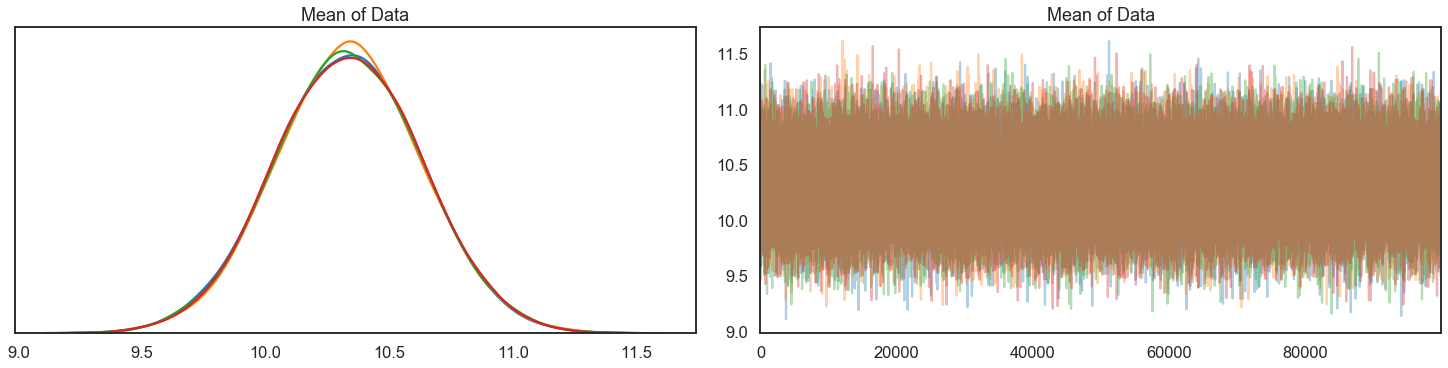

In [28]:
pm.traceplot(trace,figsize=(20,5));

In [29]:
pm.gelman_rubin(trace)

{'Mean of Data': 1.0000257421983}

"The diagnostics we have discussed are all univariate (they work perfectly when there is only 1 parameter to estimate). Other diagnostics have been derived for the multivariate case, but these are useful only when using Gibbs Samplers or other specialized versions of Metropolis-Hastings.

So most people examine univariate diagnostics for each variable, examine autocorrelation plots, acceptance rates and try to argue chain convergence based on that- unless they are using Gibbs or other specialized samplers."

### In-class exercise

Let's try to modify the code below to estimate sigma as well as the mean:



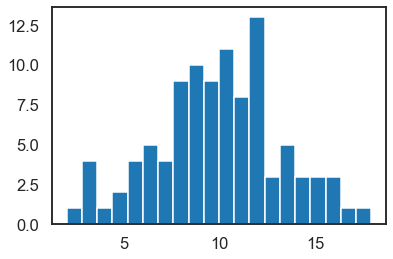

In [30]:
sigma = 3.  # standard deviation
mu = 10.    # mean
num_samples = 100  # 10**6

# sample from a normal distribution
data = stats.norm(mu, sigma).rvs(num_samples)  


# plot a histogram of the sampled data
num_bins = 20
plt.hist(data, bins=num_bins)
plt.show()


In [31]:
# parameters for the prior on mu
mu_mean_prior = 8.
mu_sd_prior = 1.5  # Note this is our prior on the std of mu

with pm.Model() as basic_model:

    # Priors for unknown model parameters
    mu = pm.Normal('Mean of Data', mu_mean_prior, mu_sd_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=data)


In [32]:
chain_length = 10000 

with basic_model:
    # obtain starting values via MAP
    startvals = pm.find_MAP(model=basic_model)
    print(startvals)
    # instantiate sampler
    step = pm.Metropolis() 

    # draw 10000 posterior samples
    trace = pm.sample(chain_length, step=step, start=startvals) 


/Users/furnstah/anaconda3/envs/8805-env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -284.59, ||grad|| = 22.104: 100%|██████████| 4/4 [00:00<00:00, 1675.71it/s]


{'Mean of Data': array(9.91288526)}


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [Mean of Data]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:05<00:00, 7522.55draws/s]
The number of effective samples is smaller than 25% for some parameters.


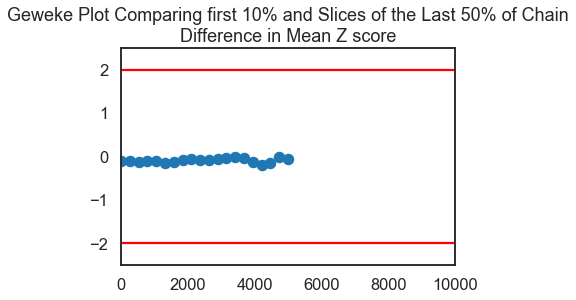

In [33]:
score=pm.geweke(trace, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], 
            marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
my_title = 'Geweke Plot Comparing first 10% and Slices of the Last 50%' +\
           ' of Chain\nDifference in Mean Z score'
plt.title(my_title)
plt.show()

Ok, we're trying it!

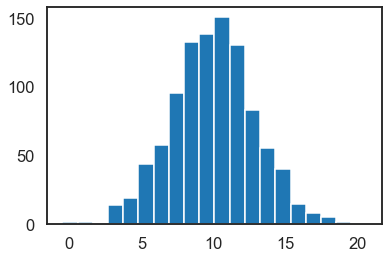

In [34]:
sigma = 3.  # standard deviation
mu = 10.    # mean
num_samples = 1000  # 100 # 10**6

# sample from a normal distribution
data = stats.norm(mu, sigma).rvs(num_samples)  


# plot a histogram of the sampled data
num_bins = 20
plt.hist(data, bins=num_bins)
plt.show()


In [35]:
# parameters for the prior on mu
mu_mean_prior = 8.
mu_sd_prior = 1.5  # Note this is our prior on the std of mu

sigma_mean_prior = 1.
sigma_sd_prior = 1.

with pm.Model() as two_param_model:

    # Priors for unknown model parameters
    mu = pm.Normal('Mean of Data', mu_mean_prior, mu_sd_prior)
    sigma = pm.Normal('SD of Data', sigma_mean_prior, sigma_sd_prior)
    
    # Likelihood (sampling distribution) of observations
    data_in = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=data)


In [36]:
chain_length = 10000 

with two_param_model:
    # obtain starting values via MAP
    startvals = pm.find_MAP(model=two_param_model)
    print(startvals)
    # instantiate sampler
    step = pm.Metropolis() 

    # draw 10000 posterior samples
    trace_two_param = pm.sample(chain_length, step=step, start=startvals) 


logp = -2,496.4, ||grad|| = 0.024393: 100%|██████████| 13/13 [00:00<00:00, 1934.23it/s]  


{'Mean of Data': array(9.94402093), 'SD of Data': array(2.91459998)}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [SD of Data]
>Metropolis: [Mean of Data]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4655.26draws/s]
The number of effective samples is smaller than 10% for some parameters.


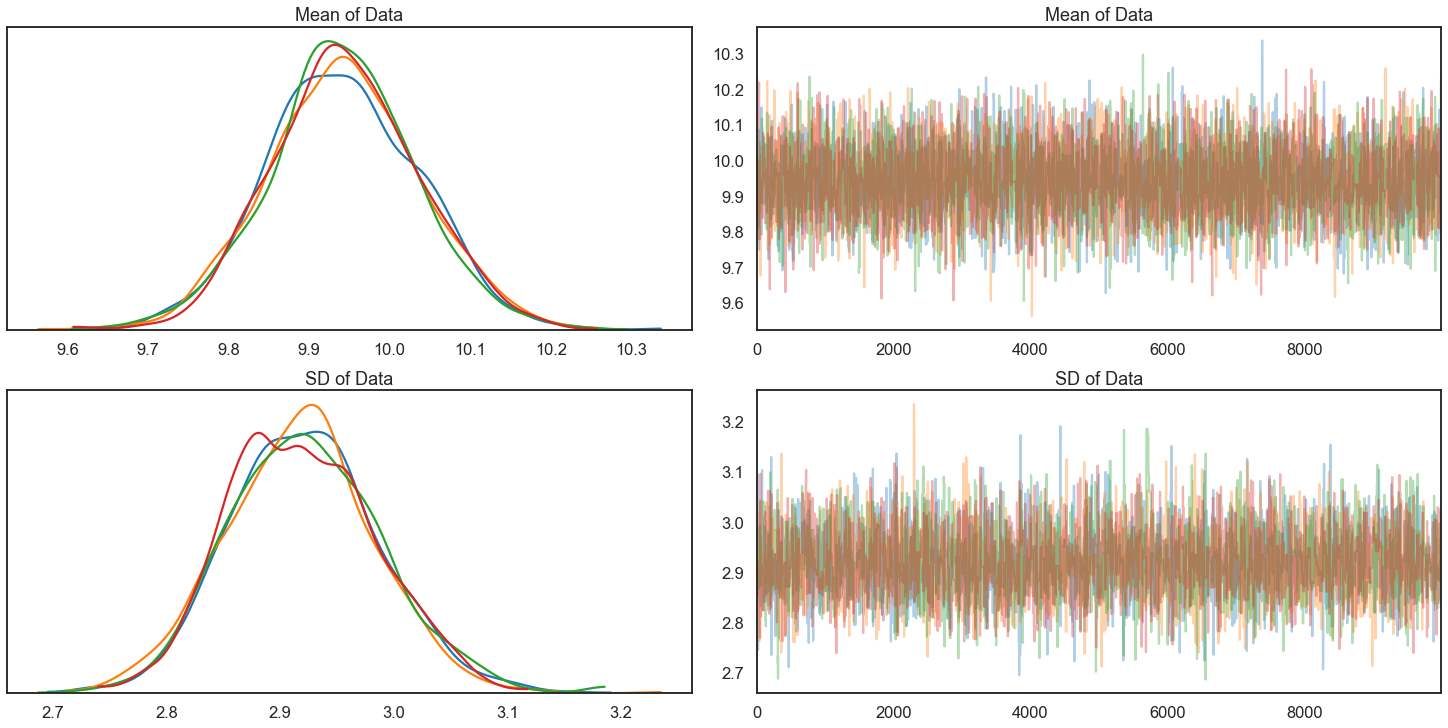

In [37]:
pm.traceplot(trace_two_param, figsize=(20,10));

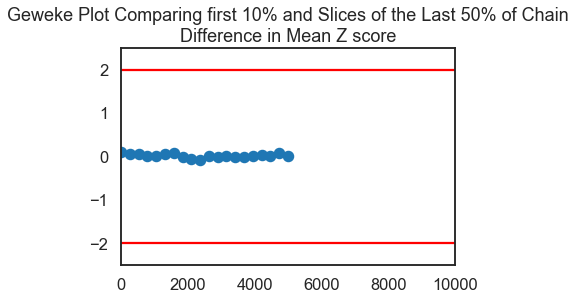

In [38]:
score=pm.geweke(trace_two_param, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['Mean of Data'][:,0],score[0]['Mean of Data'][:,1], 
            marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(0-10,.5*trace['Mean of Data'].shape[0]/2+10)
my_title = 'Geweke Plot Comparing first 10% and Slices of the Last 50%' +\
           ' of Chain\nDifference in Mean Z score'
plt.title(my_title)
plt.show()

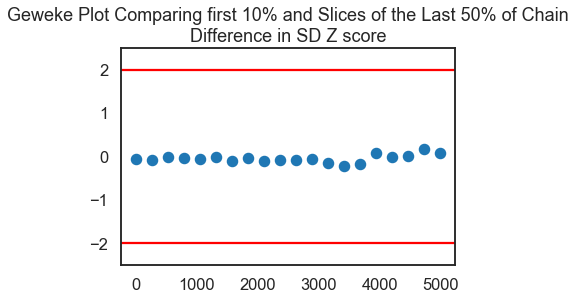

In [39]:
score=pm.geweke(trace_two_param, first=0.1, last=0.5, intervals=20)
plt.scatter(score[0]['SD of Data'][:,0],score[0]['SD of Data'][:,1], marker = 'o', s=100)
plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
#plt.xlim(0-10,.5*trace['SD of Data'].shape[0]/2+10)
plt.title('Geweke Plot Comparing first 10% and Slices of the Last 50% of Chain\nDifference in SD Z score')
plt.show()